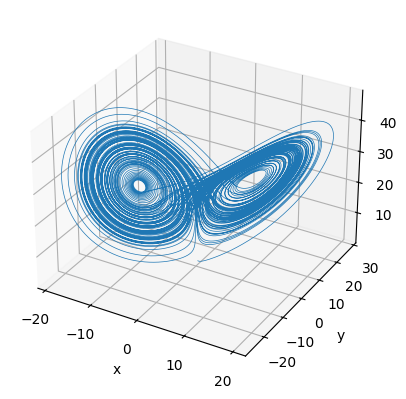

In [1]:
import numpy as np
from LorenzGen import Lorenz

delT = 0.001
num_steps = 100000

x0 = np.array([0., 1., 1.05])

xs = Lorenz(x0, delT).propagate(num_steps+3)

import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xs, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

$$
\frac{1}{\gamma} \dot{\mathbf{r}}' = - \mathbf{r}' + \mathbf{g}( (A + BW) \mathbf{r}' + \mathbf{d})
$$

In [2]:
from scipy.sparse import random, csc_matrix
from scipy.linalg import eigh
from ReservoirTanh import ReservoirTanh
# Initialize reservoir and Lorenz constant parameters
N = 450                     # Number of reservoir states
M = 3                       # Number of Lorenz states
gam = 100                   # Reservoir responsiveness
sig = 0.008                 # Attractor influence
c = 0.004                   # Control parameter
p = 0.1                     # Reservoir initial density
delT = 0.01
t_waste = 20
t_train = 200
n_w = int(t_waste / delT)
n_t = int(t_train / delT)
n = n_w + n_t
t_ind = np.arange(1, n_t + 1) + n_w
print(t_ind)

x0 = np.zeros((M, 1))
if isinstance(c, (int, float)):
    c0 = np.zeros((1, 1))
else:
    c0 = np.zeros((len(c), 1))

# Initialize reservoir and Lorenz random parameters
A = random(N, N, density=p, data_rvs=lambda size: np.random.rand(size))
A = csc_matrix(A / max(np.real(eigh(A.A)[0])) * 0.95)  # Stabilize base matrix

# Input matrices
B = 2 * sig * (np.random.rand(N, M) - 0.5)
C = 2 * c * (np.random.rand(N, 1) - 0.5)

# Fixed point
r0 = (np.random.rand(N, 1) * 0.2 + 0.8) * np.sign(np.random.rand(N, 1) - 0.5)

# Lorenz initial condition
x0 = np.random.rand(3, 1).squeeze()

Rsv = ReservoirTanh(A, B, C, r0, x0, c0, delT, gam)
L0 = Lorenz(x0, delT, [10, 28, 8/3])

[ 2001  2002  2003 ... 21998 21999 22000]


(3, 22004)


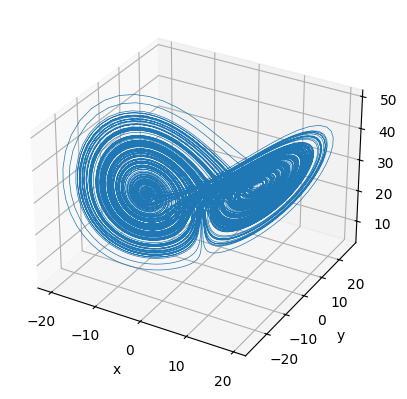

In [3]:
xs = L0.propagate(n+3)
print(xs.shape)
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xs[:, t_ind], lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [4]:
from scipy.linalg import lstsq
RT = Rsv.train(xs, np.zeros((1, 1)))
RT = RT[:, t_ind]

print('Training W')
W = lstsq(RT.T, xs[:, t_ind].T)[0].T
XT = np.dot(W, RT)
training_error = np.linalg.norm(XT - xs[:, t_ind])
print('Training error: {}'.format(training_error))

Output()

Training W
Training error: 6.301574801515936e-08


In [5]:
import jax.numpy as jnp
import numpy as np
from jax import random
from JaxReservoirTanh import JaxReservoirTanh
from scipy.sparse import random as sprandom, csc_matrix
from scipy.linalg import eigh
from LorenzGen import Lorenz
import matplotlib.pyplot as plt

# Initialize reservoir and Lorenz constant parameters
N = 450                     # Number of reservoir states
M = 3                       # Number of Lorenz states
gam = 100                   # Reservoir responsiveness
sig = 0.008                 # Attractor influence
c = 0.004                   # Control parameter
p = 0.1                     # Reservoir initial density
delT = 0.01
t_waste = 20
t_train = 200
n_w = int(t_waste / delT)
n_t = int(t_train / delT)
n = n_w + n_t
t_ind = jnp.arange(1, n_t + 1) + n_w
print(t_ind)

x0 = jnp.zeros((M, 1))
if isinstance(c, (int, float)):
    c0 = jnp.zeros((1, 1))
else:
    c0 = jnp.zeros((len(c), 1))

# Initialize reservoir and Lorenz random parameters
A = sprandom(N, N, density=p, data_rvs=lambda size: np.random.rand(size))
A = csc_matrix(A / max(np.real(eigh(A.A)[0])) * 0.95)  # Stabilize base matrix
A = jnp.array(A.todense())

# Input matrices
B = 2 * sig * (np.random.rand(N, M) - 0.5)
B = jnp.array(B)
C = 2 * c * (np.random.rand(N, 1) - 0.5)
C = jnp.array(C)

# Fixed point
r0 = (np.random.rand(N, 1) * 0.2 + 0.8) * np.sign(np.random.rand(N, 1) - 0.5)
r0 = jnp.array(r0)

# Lorenz initial condition
# key = random.PRNGKey(0)
# x0 = random.uniform(key, (3, 1)).squeeze()
x0 = np.random.rand(3, 1).squeeze()

Rsv = JaxReservoirTanh(A, B, C, r0, x0, c0, delT, gam)
L0 = Lorenz(x0, delT, [10, 28, 8/3])

[ 2001  2002  2003 ... 21998 21999 22000]


(3, 22004)


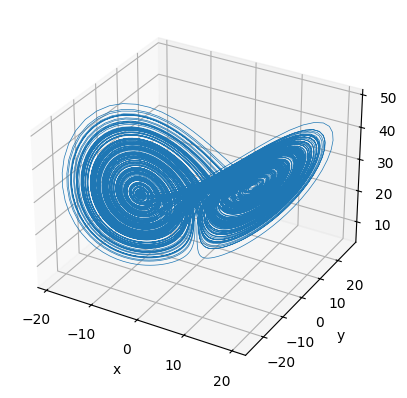

In [6]:
xs = L0.propagate(n+3)
xs = jnp.array(xs)
print(xs.shape)
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xs[:, t_ind], lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [7]:
from jax.numpy.linalg import lstsq
RT = Rsv.train(xs, jnp.zeros((1, 1)))
RT = RT[:, t_ind]

print('Training W')
W = lstsq(RT.T, xs[:, t_ind].T)[0].T
XT = jnp.dot(W, RT)
training_error = np.linalg.norm(XT - xs[:, t_ind])
print('Training error: {}'.format(training_error))

Training W
Training error: 40.78334045410156
